In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def add_project_root(project_name: str = "extrema_lab"):
    cwd = os.getcwd()
    path_parts = cwd.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        potential_root = os.sep.join(path_parts[:i])
        if os.path.basename(potential_root) == project_name:
            root = os.path.dirname(potential_root)
            if root not in sys.path:
                sys.path.append(root)
            print(f"added sys.path: {root}")
            return

    print(f"failed to fund {project_name}")


add_project_root("extrema_lab")
from extrema_lab.feature_eng.operator.utils_tools import *

added sys.path: C:\quant\work


In [3]:
symbol = "ETHUSDT"
threshold = 0.0067
feat_cal_window = 375
feat_norm_window = 375
feat_norm_rolling_mean_window = 375

future_window = 75

origin_df = process_single_symbol(
    symbol,
    str(threshold),
    feat_cal_window,
    feat_norm_window,
    feat_norm_rolling_mean_window,
)


In [4]:
import polars as pl
from typing import Tuple, Dict

def z_column_stats_grouped(df: pl.DataFrame) -> Tuple[pl.DataFrame, pl.DataFrame]:
    """
    对 df 中列名以 'z' 开头或者以 'zscaled' 结尾的列：
    1. 计算每列的 mean / min / max
    2. 按列类别分组统计整体 mean/min/max
        - 'z_start' 表示以 z 开头
        - 'zscaled_end' 表示以 zscaled 结尾
    返回：
        col_stats_df: 每列的统计结果 + 类别
        group_stats_df: 每组的统计结果
    """
    col_stats = []

    for col in df.columns:
        if col.endswith("cs"):
            category = "cs_end"

        elif col.endswith("zscaled"):
            category = "zscaled_end"

        elif col.startswith("z"):
            category = "z_start"

        else:
            continue  # 不符合条件的列跳过

        s = df[col]
        stats = {
            "col": col,
            "category": category,
            "mean": s.mean(),
            "min": s.min(),
            "max": s.max()
        }
        col_stats.append(stats)

    col_stats_df = pl.DataFrame(col_stats)

    # 按类别聚合
    group_stats_df = (
        col_stats_df
        .group_by("category")
        .agg([
            pl.col("mean").mean().alias("mean_of_means"),
            pl.col("min").min().alias("min_of_mins"),
            pl.col("max").max().alias("max_of_maxs")
        ])
    )

    return col_stats_df, group_stats_df



In [5]:
col_stats_df, group_stats_df = z_column_stats_grouped(origin_df)
# 打印每列统计的每一行
print("=== 每列统计 ===")
for row in col_stats_df.iter_rows():
    print(row)

# 打印每组统计的每一行
print("\n=== 按类别聚合统计 ===")
for row in group_stats_df.iter_rows():
    print(row)
print(col_stats_df)
print(group_stats_df)

=== 每列统计 ===
('z_oi_sum_open_interest', 'z_start', -0.14746422836614606, -3.0, 3.0)
('z_oi_sum_open_interest_value', 'z_start', 0.2638553293359994, -3.0, 3.0)
('z_funding_oi', 'z_start', -0.07523832100870381, -3.0, 3.0)
('z_premium_oi', 'z_start', 0.014573566775170207, -3.0, 3.0)
('z_factor_triplet', 'z_start', 0.09322702439465848, -3.0, 3.0)
('z_oi_sum_open_interest_value_roll_mean_ratio_12', 'z_start', 0.18795895779146965, -3.0, 3.0)
('z_oi_sum_open_interest_value_pct_change_sum_12', 'z_start', 0.1973331803625745, -3.0, 3.0)
('z_oi_sum_open_interest_value_roll_mean_ratio_72', 'z_start', 0.20218784345780594, -3.0, 3.0)
('z_oi_sum_open_interest_value_pct_change_sum_72', 'z_start', 0.17782655199791247, -3.0, 3.0)
('z_oi_sum_open_interest_value_roll_mean_ratio_144', 'z_start', 0.19427539276213138, -3.0, 3.0)
('z_oi_sum_open_interest_value_pct_change_sum_144', 'z_start', 0.17982208357204998, -3.0, 3.0)
('z_oi_sum_open_interest_value_roll_mean_ratio_288', 'z_start', 0.20358705201964633, -3

In [6]:
origin_df

timestamp,px,sum_buy_sz,sum_sell_sz,ts_duration,px_pct,bs_imbalance,oi_sum_open_interest,oi_sum_open_interest_value,funding_funding_interval_hours,funding_last_funding_rate,premium_open,adjusted_funding_rate,funding_oi,premium_oi,funding_premium,factor_triplet,premium_funding_spread,oi_sum_open_interest_value_roll_mean_ratio_12,oi_sum_open_interest_value_pct_change_sum_12,oi_sum_open_interest_value_roll_mean_ratio_72,oi_sum_open_interest_value_pct_change_sum_72,oi_sum_open_interest_value_roll_mean_ratio_144,oi_sum_open_interest_value_pct_change_sum_144,oi_sum_open_interest_value_roll_mean_ratio_288,oi_sum_open_interest_value_pct_change_sum_288,premium_funding_spread_sum_288,adjusted_funding_rate_sum_288,premium_open_sum_288,funding_oi_roll_mean_ratio_288,premium_oi_roll_mean_ratio_288,factor_triplet_roll_mean_ratio_288,premium_oi_dev_144,z_oi_sum_open_interest,z_oi_sum_open_interest_value,z_funding_oi,z_premium_oi,…,z_oi_dn_divergence_short_term_zscaled,z_sum_sz_px_pct_rol_sum_375_zscaled,z_px_velo_rol_mean_375_zscaled,z_oi_px_diff_375_zscaled,oi_di_zscaled,oi_di_long_term_zscaled,oi_di_short_term_zscaled,taker_px_pct_diff_zscaled,factor_impact_momentum_zscaled,factor_impact_sensitivity_zscaled,factor_orderflow_sz_momentum_zscaled,factor_orderflow_sz_sensitivity_zscaled,z_oi_di_zscaled,z_oi_di_long_term_zscaled,z_taker_px_pct_diff_zscaled,z_factor_impact_momentum_zscaled,z_factor_impact_sensitivity_zscaled,z_factor_orderflow_sz_momentum_zscaled,z_factor_orderflow_sz_sensitivity_zscaled,factor_order_momentum_divergence_zscaled,factor_order_sentiment_divergence_zscaled,corr_px_oi_sum_open_interest_value_375_zscaled,z_signal_px_oi_sum_open_interest_value_375_zscaled,z_factor_order_momentum_divergence_zscaled,z_factor_order_sentiment_divergence_zscaled,z_corr_px_oi_sum_open_interest_value_375_zscaled,z_px_oi_corr_activation_zscaled,px_risk_factor_zscaled,px_drawdown_zscaled,px_rebound_zscaled,z_px_risk_factor_zscaled,z_px_drawdown_zscaled,z_px_rebound_zscaled,px_dd_rb_zscaled,micro_trend_factor_375_zscaled,z_px_dd_rb_zscaled,z_micro_trend_factor_375_zscaled
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1719796282493000,3477.9,29484.724,18226.706,3.07766e8,0.006701,11258.018,1.17340256e8,341066.7279,8.0,0.0001,-0.00027,0.0000125,4.263334,-92.200569,-3.3791e-9,-0.001153,-0.000283,0.999391,-0.001693,0.999263,-0.00131,0.999263,-0.00131,0.999263,-0.00131,-0.006014,0.000175,-0.005839,0.999263,0.647608,0.647608,-0.352392,1.585299,-0.926717,-0.926715,1.219985,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1719797254444000,3501.21,65436.02,55334.441,9.71951e8,0.006702,10101.579,1.17680046e8,337419.502166,8.0,0.0001,-0.000143,0.0000125,4.217744,-48.409576,-1.7934e-9,-0.000605,-0.000156,0.991359,-0.011746,0.990301,-0.012017,0.990301,-0.012017,0.990301,-0.012017,-0.00646,0.000213,-0.006248,0.990301,0.385946,0.385946,-0.614054,3.0,-2.296981,-2.29698,1.103566,…,0.0,0.30443,0.30443,-0.30443,0.30443,0.304416,0.304415,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,-0.304428,0.30443,0.30443,0.0,-0.30443,0.30443,0.30443,0.0,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.0
1719823216718000,3477.74,249211.968,259847.697,2.5962e10,-0.006703,-10635.729,1.19481635e8,343241.397515,8.0,0.0001,-0.000329,0.0000125,4.290517,-113.015663,-4.1157e-9,-0.001413,-0.000342,1.002978,0.005207,1.00889,0.013291,1.010005,0.005138,1.010005,0.005138,-0.035794,0.0013,-0.034494,1.010005,1.001546,1.001546,0.001546,1.884827,1.943581,1.94358,-0.00383,…,0.0,-0.056327,-0.054522,0.069674,-0.065987,0.014366,0.009673,0.018932,-0.06198,-0.06693,0.300058,0.471441,-0.069616,

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px_regression(
    y_true,           # 真实未来收益率
    y_pred,           # 模型预测收益率
    px,               # 价格
    std_array=None,   # 可选标准差
    n=700,
    m=-1,
    alpha=1.0
):
    # 截取最近 n 行
    y_true_slice = y_true[n:m]
    y_pred_slice = y_pred[n:m]
    px_slice = px[n:m]
    std_slice = std_array[n:m] if std_array is not None else None

    time_index = np.arange(len(y_true_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 价格线
    ax1.plot(time_index, px_slice, color='tab:gray', label='Price (px)', linewidth=1.5)
    if std_slice is not None:
        ax1.plot(time_index, px_slice + alpha * std_slice, linestyle=':', color='gray', alpha=0.4, label='+std')
        ax1.plot(time_index, px_slice - alpha * std_slice, linestyle=':', color='gray', alpha=0.4, label='-std')

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Time Index")
    ax1.tick_params(axis='y', labelcolor='black')

    # 创建第二个 y 轴：收益率
    ax2 = ax1.twinx()
    ax2.plot(time_index, y_true_slice, label='True Future Return', color='tab:blue', linewidth=1.5)
    ax2.plot(time_index, y_pred_slice, label='Predicted Return', color='tab:green', linestyle='--', linewidth=1.5)
    ax2.set_ylabel("Return")
    ax2.tick_params(axis='y', labelcolor='black')

    # 图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Price, True Return, and Predicted Return (Last {n} rows)")
    plt.tight_layout()
    plt.show()


In [9]:
import polars as pl
import numpy as np
from tqdm import tqdm


px_np = origin_df["px"].to_numpy()
ts_np = origin_df["timestamp"].to_numpy()  # 确保是 numpy array

def future_return_and_duration(
    px: np.ndarray,
    ts: np.ndarray,   # 时间戳（int 或 datetime64）
    window: int,
    use_log_return: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    n = len(px)
    returns = np.full(n, np.nan)
    durations = np.full(n, np.nan)

    for i in tqdm(range(n - window), desc="Calculating future returns & durations"):
        if px[i] > 0:
            if use_log_return:
                returns[i] = np.log(px[i + window] / px[i])
            else:
                returns[i] = (px[i + window] - px[i]) / px[i]

            durations[i] = ts[i + window] - ts[i]  # 保持单位不变（ms/us）
        else:
            returns[i] = np.nan
            durations[i] = np.nan

    return returns, durations

# 计算未来收益率标签
future_return_label, duration_label = future_return_and_duration(
    px_np, ts_np, window=future_window, use_log_return=True
)
# 加入 DataFrame
a_df = origin_df.with_columns([
    pl.Series("future_return", future_return_label),
    pl.Series("duration", duration_label),
])

# 去除 NaN
a_df_filtered = a_df.filter(pl.col("future_return").is_not_null())
a_df_filtered = clean_df_drop_nulls(a_df_filtered)

# 可选：按周分割
split_dataframes = split_df_by_month(a_df_filtered)
print("num split dfs: ", len(split_dataframes))

def print_stats(arr, name):
    arr_clean = arr[~np.isnan(arr)]
    print(f"{name}:")
    print(f"  count = {len(arr_clean)}")
    print(f"  mean  = {np.mean(arr_clean):.6f}")
    print(f"  std   = {np.std(arr_clean):.6f}")
    print(f"  min   = {np.min(arr_clean):.6f}")
    print(f"  max   = {np.max(arr_clean):.6f}\n")

def print_stats_duration(arr, name="duration"):
    arr_clean = arr[~np.isnan(arr)]

    arr_sec = arr_clean / 1_000_000          # 微秒 -> 秒
    arr_min = arr_sec / 60                    # 秒 -> 分钟
    arr_hr  = arr_sec / 3600                  # 秒 -> 小时

    print(f"{name} statistics:")
    print(f"  count = {len(arr_clean)}")
    print(f"  mean  = {np.mean(arr_sec):.6f} s / {np.mean(arr_min):.3f} min / {np.mean(arr_hr):.3f} hr")
    print(f"  std   = {np.std(arr_sec):.6f} s / {np.std(arr_min):.3f} min / {np.std(arr_hr):.3f} hr")
    print(f"  min   = {np.min(arr_sec):.6f} s / {np.min(arr_min):.3f} min / {np.min(arr_hr):.3f} hr")
    print(f"  max   = {np.max(arr_sec):.6f} s / {np.max(arr_min):.3f} min / {np.max(arr_hr):.3f} hr\n")


print_stats(future_return_label, "future_return")
print_stats_duration(duration_label, "duration")

Calculating future returns & durations: 100%|██████████| 13960/13960 [00:00<00:00, 949787.24it/s]


Converted Polars DataFrame to Pandas
Null counts per column:
Series([], dtype: int64)
Dropping columns with nulls greater than 500000: []
Shape after dropping columns: (14035, 271)
Shape after dropping rows with nulls: (14035, 271)
num split dfs:  14
future_return:
  count = 13960
  mean  = 0.001739
  std   = 0.061950
  min   = -0.245030
  max   = 0.208478

duration statistics:
  count = 13960
  mean  = 195506.815722 s / 3258.447 min / 54.307 hr
  std   = 130030.622076 s / 2167.177 min / 36.120 hr
  min   = 200.328000 s / 3.339 min / 0.056 hr
  max   = 634516.084000 s / 10575.268 min / 176.254 hr



In [10]:
# duration 原来是微秒 (us)，先转换成秒
duration_sec = duration_label / 1_000_000

# origin_df 的 timestamp 转成 numpy
timestamps = origin_df["timestamp"].to_numpy()
future_returns = future_return_label  # 已经是 numpy

# 阈值，例如 1 小时 = 3600 秒
threshold_sec = 3600
short_idx = np.where(duration_sec < threshold_sec)[0]

print(f"Number of short durations (<1 hr): {len(short_idx)}\n")

# 找出最短 10 个 duration
short_idx_sorted = short_idx[np.argsort(duration_sec[short_idx])][:10]

for i in short_idx_sorted:
    print(f"timestamp: {timestamps[i]}, "
          f"future_return: {future_returns[i]:.6f}, "
          f"duration: {duration_sec[i]:.2f} s / {duration_sec[i]/60:.2f} min")



Number of short durations (<1 hr): 284

timestamp: 1738548370591000, future_return: -0.056636, duration: 200.33 s / 3.34 min
timestamp: 1738548383011000, future_return: -0.056645, duration: 201.79 s / 3.36 min
timestamp: 1738548387995000, future_return: -0.043231, duration: 209.09 s / 3.48 min
timestamp: 1738548389393000, future_return: -0.029809, duration: 228.02 s / 3.80 min
timestamp: 1738548331411000, future_return: -0.070071, duration: 238.48 s / 3.97 min
timestamp: 1738548400564000, future_return: -0.029794, duration: 240.55 s / 4.01 min
timestamp: 1738548393251000, future_return: -0.029811, duration: 241.34 s / 4.02 min
timestamp: 1738548315170000, future_return: -0.070089, duration: 242.76 s / 4.05 min
timestamp: 1738548325100000, future_return: -0.083480, duration: 243.04 s / 4.05 min
timestamp: 1738548318205000, future_return: -0.070076, duration: 248.40 s / 4.14 min


In [11]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


In [12]:
n_train_terms = 6 # 可配置
n_val_terms = 1    # 一般 1 周验证
n_test_terms = 1   # 后 1 周做 test

exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol']
target_col = "future_return"
feature_cols = [
    col for col in origin_df.columns
    if (col.endswith("_zscaled") and col.startswith("z_"))
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)
print(len(feature_cols))
# feature_cols = ["oi_di_long_term"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None

ic_lst = []
for i in range(len(split_dataframes) - n_train_terms - n_val_terms + 1):
    train_dfs = split_dataframes[i : i + n_train_terms]
    val_dfs = split_dataframes[i + n_train_terms : i + n_train_terms + n_val_terms]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_terms-1}, Val {i+n_train_terms}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = val_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    params = {
        # 模型结构参数
        "n_d": 16,                      # 决策输出维度
        "n_a": 16,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-5,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "sparsemax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 1e-2},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 20,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "max_epochs": 500,
        "patience": 75,
        "batch_size": 2048,
        "virtual_batch_size": 512,
    }

    inc_fit_params = {
        "max_epochs": 50,
        "patience": 10,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    # TabNet_incremental 训练
    tabnet = TabNetRegressor(**params)
    tabnet.fit(
        X_train=X_train.values, 
        y_train=y_train.values.reshape(-1, 1),
        **init_fit_params,
    )

    y_val_pred = tabnet.predict(X_val.values)
    print("回归评估 (Val):")
    print("MSE:", mean_squared_error(y_val, y_val_pred))
    print("MAE:", mean_absolute_error(y_val, y_val_pred))
    print("R²:", r2_score(y_val, y_val_pred))

    ic, _ = spearmanr(y_val, y_val_pred)
    print("IC (val):", ic)
    ic_lst.append(ic)
    # 可选：定义置信区间（过滤极端预测）
    conf_thresh = 0.005  # 例如：只看预测收益率 > 0.5% 或 < -0.5%
    mask = (np.abs(y_val_pred) >= conf_thresh)
    print("过滤高置信度样本数量: ", mask.sum())
    
    # 收集预测结果（Val 可选，Test 常用于回测）
    current_window_results = pd.DataFrame({
        'timestamp': timestamps_val,  # 注意：用 test 数据
        'symbol': symbol,
        'true_label': y_val,
        'predicted_value': y_val_pred.ravel(),  # 保证是一维
        'px': px_val,
    })
    
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'val_period': f"{val_df['timestamp_dt'][0]} to {val_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        # 'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_terms} Evaluation Completed")
 
# 存储该周评估信息
term_results = {
    'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
    'val_period': f"{val_df['timestamp_dt'][0]} to {val_df['timestamp_dt'][-1]}",
    'TabNet_MSE': mean_squared_error(y_val, y_val_pred),
    'TabNet_MAE': mean_absolute_error(y_val, y_val_pred),
    'TabNet_R2': r2_score(y_val, y_val_pred),
    'HighConfidenceCount': int(mask.sum())
}
results.append(term_results)

print(f"Test Week {i + n_train_terms} Evaluation Completed")

# 合并所有窗口的预测结果
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}")

# 字符串化整体时间范围
overall_start = str(overall_start)
overall_end = str(overall_end)
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")

60
Fold 0: Train 0~5, Val 6
Train: 2024-07-01 01:11:22.493000 to 2024-12-31 20:56:55.308000
Val: 2025-01-01 00:39:35.104000 to 2025-01-31 22:52:29.952000


C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.01347 |  0:00:00s
epoch 20 | loss: 0.01209 |  0:00:01s
epoch 40 | loss: 0.00381 |  0:00:03s
epoch 60 | loss: 0.00298 |  0:00:05s
epoch 80 | loss: 0.00238 |  0:00:06s
epoch 100| loss: 0.0017  |  0:00:08s
epoch 120| loss: 0.00152 |  0:00:10s
epoch 140| loss: 0.00145 |  0:00:11s
epoch 160| loss: 0.00126 |  0:00:13s
epoch 180| loss: 0.00117 |  0:00:15s
epoch 200| loss: 0.00117 |  0:00:16s
epoch 220| loss: 0.00114 |  0:00:18s
epoch 240| loss: 0.0008  |  0:00:20s
epoch 260| loss: 0.00079 |  0:00:21s
epoch 280| loss: 0.00084 |  0:00:23s
epoch 300| loss: 0.00094 |  0:00:25s
epoch 320| loss: 0.00089 |  0:00:26s
epoch 340| loss: 0.0008  |  0:00:28s
epoch 360| loss: 0.00076 |  0:00:29s
epoch 380| loss: 0.00069 |  0:00:31s
epoch 400| loss: 0.00065 |  0:00:32s
epoch 420| loss: 0.00072 |  0:00:34s
epoch 440| loss: 0.00063 |  0:00:36s
epoch 460| loss: 0.00073 |  0:00:37s
epoch 480| loss: 0.00062 |  0:00:39s
回归评估 (Val):
MSE: 0.0047234902486116585
MAE: 0.054763520883378665
R²: -0.724

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.00702 |  0:00:01s
epoch 40 | loss: 0.00358 |  0:00:03s
epoch 60 | loss: 0.00271 |  0:00:04s
epoch 80 | loss: 0.00219 |  0:00:06s
epoch 100| loss: 0.00173 |  0:00:07s
epoch 120| loss: 0.0017  |  0:00:09s
epoch 140| loss: 0.00163 |  0:00:10s
epoch 160| loss: 0.00129 |  0:00:12s
epoch 180| loss: 0.00116 |  0:00:13s
epoch 200| loss: 0.00121 |  0:00:15s
epoch 220| loss: 0.00108 |  0:00:16s
epoch 240| loss: 0.00105 |  0:00:18s
epoch 260| loss: 0.00079 |  0:00:20s
epoch 280| loss: 0.00077 |  0:00:22s
epoch 300| loss: 0.00089 |  0:00:24s
epoch 320| loss: 0.00076 |  0:00:25s
epoch 340| loss: 0.00092 |  0:00:27s
epoch 360| loss: 0.00083 |  0:00:29s
epoch 380| loss: 0.00089 |  0:00:30s
epoch 400| loss: 0.00064 |  0:00:32s
epoch 420| loss: 0.00078 |  0:00:34s
epoch 440| loss: 0.00065 |  0:00:35s
epoch 460| loss: 0.00054 |  0:00:37s
epoch 480| loss: 0.00058 |  0:00:38s
回归评估 (Val):
MSE: 0.037481496779301175
MAE: 0.11343083339690611
R²: -9.244378324460833
IC (val): 0.16834692238165

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.01313 |  0:00:01s
epoch 40 | loss: 0.00403 |  0:00:03s
epoch 60 | loss: 0.00251 |  0:00:04s
epoch 80 | loss: 0.00192 |  0:00:06s
epoch 100| loss: 0.00177 |  0:00:08s
epoch 120| loss: 0.00158 |  0:00:09s
epoch 140| loss: 0.00137 |  0:00:11s
epoch 160| loss: 0.00126 |  0:00:12s
epoch 180| loss: 0.00113 |  0:00:14s
epoch 200| loss: 0.0011  |  0:00:16s
epoch 220| loss: 0.0011  |  0:00:17s
epoch 240| loss: 0.00091 |  0:00:19s
epoch 260| loss: 0.00087 |  0:00:21s
epoch 280| loss: 0.00087 |  0:00:22s
epoch 300| loss: 0.00074 |  0:00:24s
epoch 320| loss: 0.0008  |  0:00:25s
epoch 340| loss: 0.00074 |  0:00:27s
epoch 360| loss: 0.00068 |  0:00:28s
epoch 380| loss: 0.00073 |  0:00:30s
epoch 400| loss: 0.00065 |  0:00:32s
epoch 420| loss: 0.00062 |  0:00:34s
epoch 440| loss: 0.00071 |  0:00:35s
epoch 460| loss: 0.0006  |  0:00:37s
epoch 480| loss: 0.00058 |  0:00:38s
回归评估 (Val):
MSE: 0.007625443393562902
MAE: 0.07032048801713951
R²: -1.1295814449085815
IC (val): -0.224762444506

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.00738 |  0:00:02s
epoch 40 | loss: 0.0038  |  0:00:04s
epoch 60 | loss: 0.00236 |  0:00:07s
epoch 80 | loss: 0.00199 |  0:00:09s
epoch 100| loss: 0.00177 |  0:00:12s
epoch 120| loss: 0.00131 |  0:00:15s
epoch 140| loss: 0.0014  |  0:00:17s
epoch 160| loss: 0.00117 |  0:00:19s
epoch 180| loss: 0.00114 |  0:00:22s
epoch 200| loss: 0.00093 |  0:00:24s
epoch 220| loss: 0.00142 |  0:00:26s
epoch 240| loss: 0.00118 |  0:00:29s
epoch 260| loss: 0.0009  |  0:00:32s
epoch 280| loss: 0.00092 |  0:00:34s
epoch 300| loss: 0.00094 |  0:00:36s
epoch 320| loss: 0.00076 |  0:00:39s
epoch 340| loss: 0.0007  |  0:00:41s
epoch 360| loss: 0.00066 |  0:00:44s
epoch 380| loss: 0.00061 |  0:00:46s
epoch 400| loss: 0.0006  |  0:00:49s
epoch 420| loss: 0.00055 |  0:00:51s
epoch 440| loss: 0.00052 |  0:00:53s
epoch 460| loss: 0.00052 |  0:00:56s
epoch 480| loss: 0.00054 |  0:00:58s
回归评估 (Val):
MSE: 0.006069947326339834
MAE: 0.05902695494255608
R²: -0.6617647627332264
IC (val): 0.0037482210144

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.00688 |  0:00:02s
epoch 40 | loss: 0.00375 |  0:00:04s
epoch 60 | loss: 0.00244 |  0:00:07s
epoch 80 | loss: 0.00196 |  0:00:09s
epoch 100| loss: 0.00174 |  0:00:11s
epoch 120| loss: 0.00145 |  0:00:13s
epoch 140| loss: 0.00125 |  0:00:15s
epoch 160| loss: 0.00121 |  0:00:17s
epoch 180| loss: 0.00114 |  0:00:20s
epoch 200| loss: 0.00113 |  0:00:22s
epoch 220| loss: 0.00086 |  0:00:25s
epoch 240| loss: 0.00089 |  0:00:27s
epoch 260| loss: 0.00078 |  0:00:29s
epoch 280| loss: 0.00075 |  0:00:32s
epoch 300| loss: 0.0007  |  0:00:34s
epoch 320| loss: 0.00076 |  0:00:36s
epoch 340| loss: 0.00061 |  0:00:39s
epoch 360| loss: 0.00067 |  0:00:41s
epoch 380| loss: 0.00064 |  0:00:43s
epoch 400| loss: 0.0006  |  0:00:46s
epoch 420| loss: 0.0006  |  0:00:48s
epoch 440| loss: 0.00057 |  0:00:51s
epoch 460| loss: 0.00059 |  0:00:53s
epoch 480| loss: 0.00051 |  0:00:55s
回归评估 (Val):
MSE: 0.005412033596204314
MAE: 0.059346462467047625
R²: -0.4305797878213977
IC (val): 0.136674493305

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.00708 |  0:00:02s
epoch 40 | loss: 0.00399 |  0:00:04s
epoch 60 | loss: 0.00288 |  0:00:07s
epoch 80 | loss: 0.00233 |  0:00:09s
epoch 100| loss: 0.00181 |  0:00:12s
epoch 120| loss: 0.00155 |  0:00:14s
epoch 140| loss: 0.00152 |  0:00:16s
epoch 160| loss: 0.00127 |  0:00:19s
epoch 180| loss: 0.0013  |  0:00:21s
epoch 200| loss: 0.00112 |  0:00:23s
epoch 220| loss: 0.00095 |  0:00:25s
epoch 240| loss: 0.00087 |  0:00:28s
epoch 260| loss: 0.00096 |  0:00:30s
epoch 280| loss: 0.00087 |  0:00:32s
epoch 300| loss: 0.00075 |  0:00:35s
epoch 320| loss: 0.00074 |  0:00:37s
epoch 340| loss: 0.00073 |  0:00:39s
epoch 360| loss: 0.00085 |  0:00:41s
epoch 380| loss: 0.00071 |  0:00:43s
epoch 400| loss: 0.00071 |  0:00:46s
epoch 420| loss: 0.0007  |  0:00:48s
epoch 440| loss: 0.00066 |  0:00:50s
epoch 460| loss: 0.00059 |  0:00:53s
epoch 480| loss: 0.00057 |  0:00:55s
回归评估 (Val):
MSE: 0.0062458401769266555
MAE: 0.06912965851953393
R²: -0.45378161492823477
IC (val): 0.28834034707

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.00739 |  0:00:02s
epoch 40 | loss: 0.00383 |  0:00:04s
epoch 60 | loss: 0.00244 |  0:00:06s
epoch 80 | loss: 0.00227 |  0:00:09s
epoch 100| loss: 0.0019  |  0:00:11s
epoch 120| loss: 0.00202 |  0:00:13s
epoch 140| loss: 0.00232 |  0:00:16s
epoch 160| loss: 0.00153 |  0:00:18s
epoch 180| loss: 0.00125 |  0:00:20s
epoch 200| loss: 0.00112 |  0:00:23s
epoch 220| loss: 0.00095 |  0:00:25s
epoch 240| loss: 0.00094 |  0:00:27s
epoch 260| loss: 0.00083 |  0:00:30s
epoch 280| loss: 0.00083 |  0:00:32s
epoch 300| loss: 0.0008  |  0:00:34s
epoch 320| loss: 0.00076 |  0:00:37s
epoch 340| loss: 0.0007  |  0:00:39s
epoch 360| loss: 0.00068 |  0:00:41s
epoch 380| loss: 0.00066 |  0:00:44s
epoch 400| loss: 0.00059 |  0:00:46s
epoch 420| loss: 0.00063 |  0:00:48s
epoch 440| loss: 0.00062 |  0:00:51s
epoch 460| loss: 0.00059 |  0:00:53s
epoch 480| loss: 0.00051 |  0:00:55s
回归评估 (Val):
MSE: 0.011348546139207775
MAE: 0.08539564264878916
R²: -2.3313750471994776
IC (val): -0.009429822731

C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\EI_Lab\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 20 | loss: 0.01074 |  0:00:02s
epoch 40 | loss: 0.00343 |  0:00:04s
epoch 60 | loss: 0.00237 |  0:00:07s
epoch 80 | loss: 0.00173 |  0:00:09s
epoch 100| loss: 0.00147 |  0:00:11s
epoch 120| loss: 0.00136 |  0:00:14s
epoch 140| loss: 0.00133 |  0:00:16s
epoch 160| loss: 0.00124 |  0:00:18s
epoch 180| loss: 0.00108 |  0:00:21s
epoch 200| loss: 0.00102 |  0:00:23s
epoch 220| loss: 0.00088 |  0:00:25s
epoch 240| loss: 0.00088 |  0:00:27s
epoch 260| loss: 0.00091 |  0:00:29s
epoch 280| loss: 0.00087 |  0:00:32s
epoch 300| loss: 0.00071 |  0:00:34s
epoch 320| loss: 0.0009  |  0:00:36s
epoch 340| loss: 0.00067 |  0:00:38s
epoch 360| loss: 0.00071 |  0:00:40s
epoch 380| loss: 0.0007  |  0:00:43s
epoch 400| loss: 0.00062 |  0:00:45s
epoch 420| loss: 0.00062 |  0:00:47s
epoch 440| loss: 0.00075 |  0:00:49s
epoch 460| loss: 0.0006  |  0:00:52s
epoch 480| loss: 0.00054 |  0:00:54s
回归评估 (Val):
MSE: 0.00686287469298139
MAE: 0.0684557307036756
R²: -0.7320302404501375
IC (val): 0.042713823598476

Mean IC: 0.0676, Std IC: 0.1532, IR: 0.4411


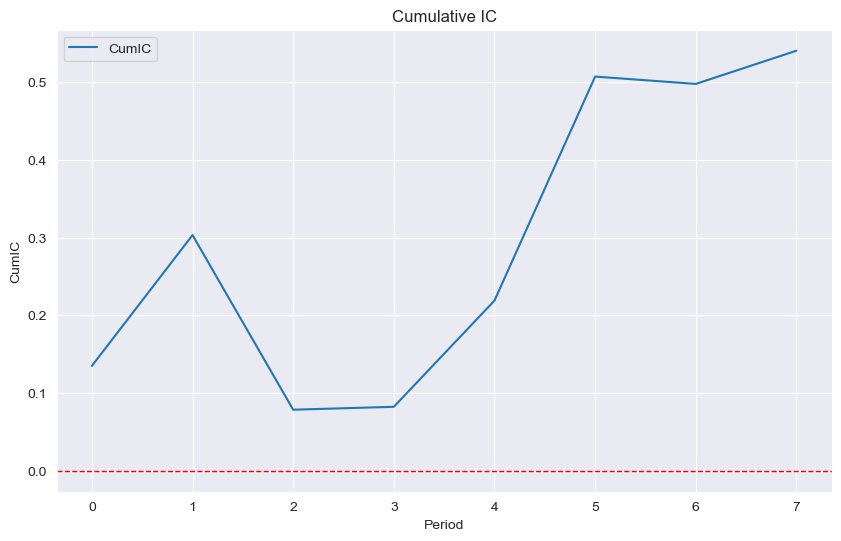

In [13]:

ic_arr = np.array(ic_lst)

mean_ic = np.mean(ic_arr)
std_ic = np.std(ic_arr, ddof=1)  # 样本标准差
ir = mean_ic / std_ic if std_ic != 0 else np.nan

print(f"Mean IC: {mean_ic:.4f}, Std IC: {std_ic:.4f}, IR: {ir:.4f}")

cum_ic = np.cumsum(ic_arr)

plt.figure(figsize=(10, 6))
plt.plot(cum_ic, label="CumIC")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Cumulative IC")
plt.xlabel("Period")
plt.ylabel("CumIC")
plt.legend()
plt.show()

In [14]:
print(len(X_val.columns))

60


In [15]:
explain_matrix, masks = tabnet.explain(X_val.values)


Top 20 Features by Importance:

z_factor_impact_sensitivity_zscaled      Importance: 0.321937
z_px_pct_rol_sum_10_zscaled              Importance: 0.285472
z_funding_oi_zscaled                     Importance: 0.191175
z_corr_px_oi_sum_open_interest_value_375_zscaled Importance: 0.160660
z_oi_sum_open_interest_value_pct_change_sum_72_zscaled Importance: 0.129091
z_factor_triplet_roll_mean_ratio_288_zscaled Importance: 0.124279
z_signal_px_oi_sum_open_interest_value_375_zscaled Importance: 0.102077
z_log1p_sum_sz_375_rsi_375_zscaled       Importance: 0.097466
z_oi_sum_open_interest_value_roll_mean_ratio_288_zscaled Importance: 0.090795
z_premium_open_sum_288_zscaled           Importance: 0.085896
z_px_pct_rol_sum_20_zscaled              Importance: 0.079790
z_log1p_ts_velo_rol_mean_375_zscaled     Importance: 0.077538
z_premium_oi_zscaled                     Importance: 0.071751
z_factor_order_momentum_divergence_zscaled Importance: 0.061820
z_px_pct_rol_sum_375_zscaled             Impor

C:\Users\Grayman\AppData\Local\Temp\ipykernel_43736\3019990946.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


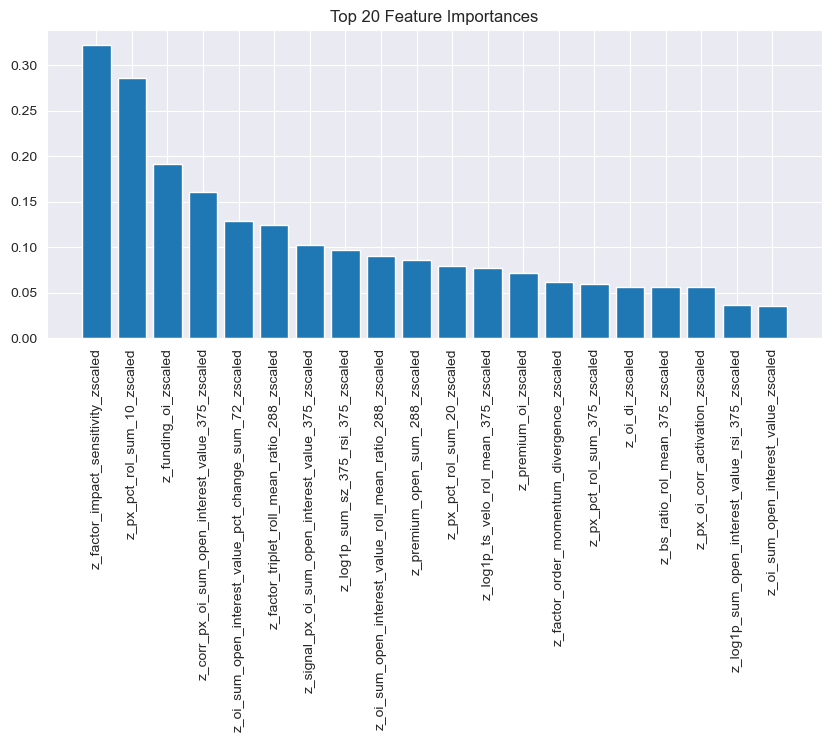

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [17]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [20 29 33 53]
对应的权重: [0.38573146 0.40656662 0.15235496 0.05534697]
特征: z_px_pct_rol_sum_10_zscaled, 权重: 0.3857
特征: z_log1p_ts_velo_rol_mean_375_zscaled, 权重: 0.4066
特征: z_log1p_sum_open_interest_value_rsi_375_zscaled, 权重: 0.1524
特征: z_corr_px_oi_sum_open_interest_value_375_zscaled, 权重: 0.0553


In [18]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [19]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共4个非零特征）:
  特征: z_log1p_ts_velo_rol_mean_375_zscaled 权重: 0.4066
  特征: z_px_pct_rol_sum_10_zscaled    权重: 0.3857
  特征: z_log1p_sum_open_interest_value_rsi_375_zscaled 权重: 0.1524
  特征: z_corr_px_oi_sum_open_interest_value_375_zscaled 权重: 0.0553

🧭 Step 1（共2个非零特征）:
  特征: z_oi_sum_open_interest_value_pct_change_sum_72_zscaled 权重: 0.7296
  特征: z_oi_sum_open_interest_value_roll_mean_ratio_144_zscaled 权重: 0.2704

🧭 Step 2（共2个非零特征）:
  特征: z_log1p_sum_sz_375_rsi_375_zscaled 权重: 0.9235
  特征: z_oi_sum_open_interest_value_zscaled 权重: 0.0765


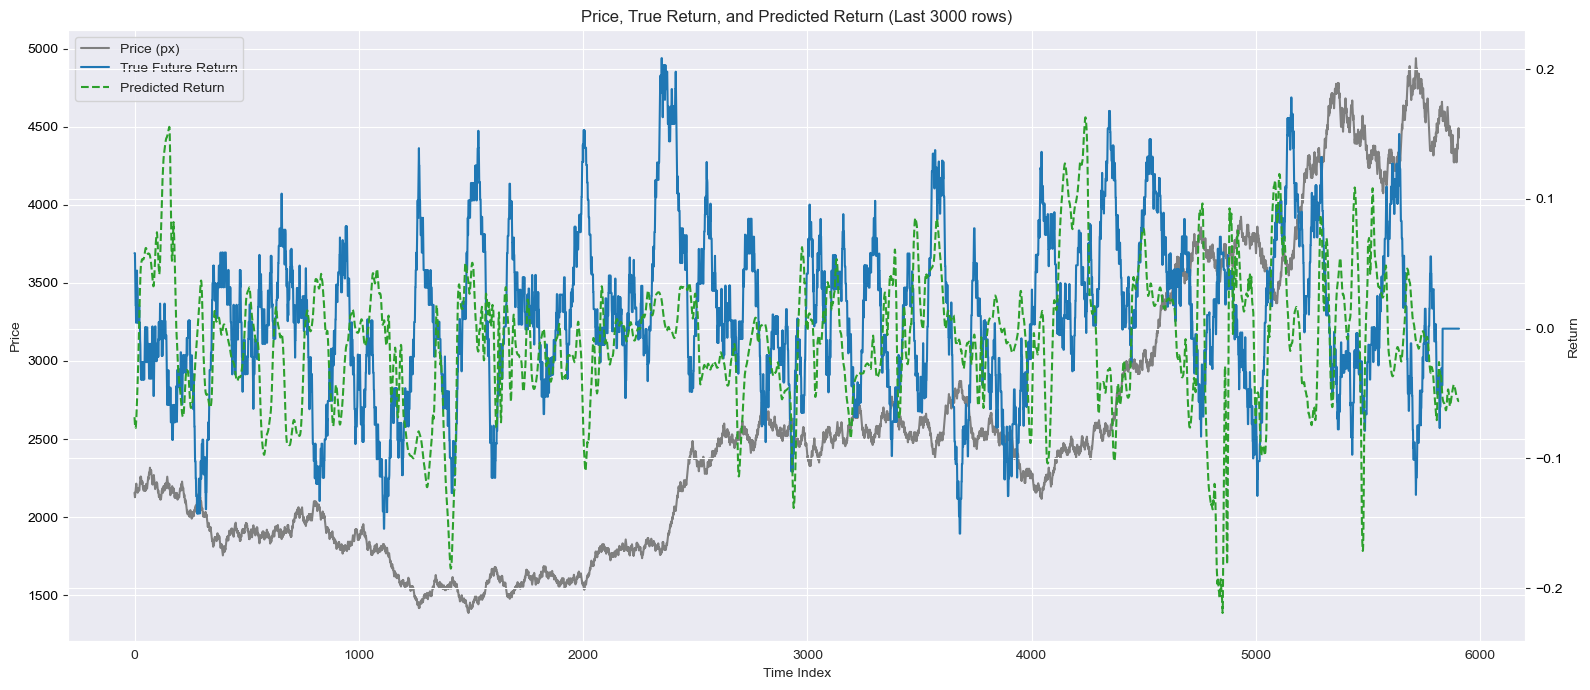

,timestamp,symbol,true_label,predicted_value,px,predicted_prob_rolling_mean,predicted_prob_rolling_mean_reverse
0,1.735692e+15,ETHUSDT,0.072669,0.079564,3358.94,0.079564,0.920436
1,1.735713e+15,ETHUSDT,0.072668,0.084839,3336.43,0.082201,0.917799
2,1.735724e+15,ETHUSDT,0.072667,0.087599,3314.07,0.084001,0.915999
3,1.735726e+15,ETHUSDT,0.059087,0.093087,3336.28,0.086272,0.913728
4,1.735740e+15,ETHUSDT,0.059086,0.077018,3358.64,0.084421,0.915579
...,...,...,...,...,...,...,...
8902,1.756602e+15,ETHUSDT,0.000000,-0.055218,4460.50,-0.055622,1.055622
8903,1.756645e+15,ETHUSDT,0.000000,-0.053092,4490.39,-0.055674,1.055674
8904,1.756649e+15,ETHUSDT,0.000000,-0.052907,4460.30,-0.055865,1.055865
8905,1.756681e+15,ETHUSDT,0.000000,-0.052767,4430.41,-0.055814,1.055814


In [20]:
rolling_window_size = 10

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_value'].rolling(window=rolling_window_size, min_periods=1).mean()
final_predictions_df['predicted_prob_rolling_mean_reverse'] = 1-final_predictions_df['predicted_prob_rolling_mean']

plot_last_n_rows_with_px_regression(
    y_true=final_predictions_df['true_label'],
    y_pred=final_predictions_df['predicted_prob_rolling_mean'],
    px=final_predictions_df['px'],
    n=3000,
    alpha=1.5
)

final_predictions_df

In [21]:
# 计算未来收益

final_predictions_df['future_return'] = (
    final_predictions_df['px'].shift(-future_window) / final_predictions_df['px'] - 1
)


from scipy.stats import spearmanr

signal_col = 'predicted_value'
return_col = 'future_return'

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


Rank IC: 0.0482, p-value: 5.843e-06


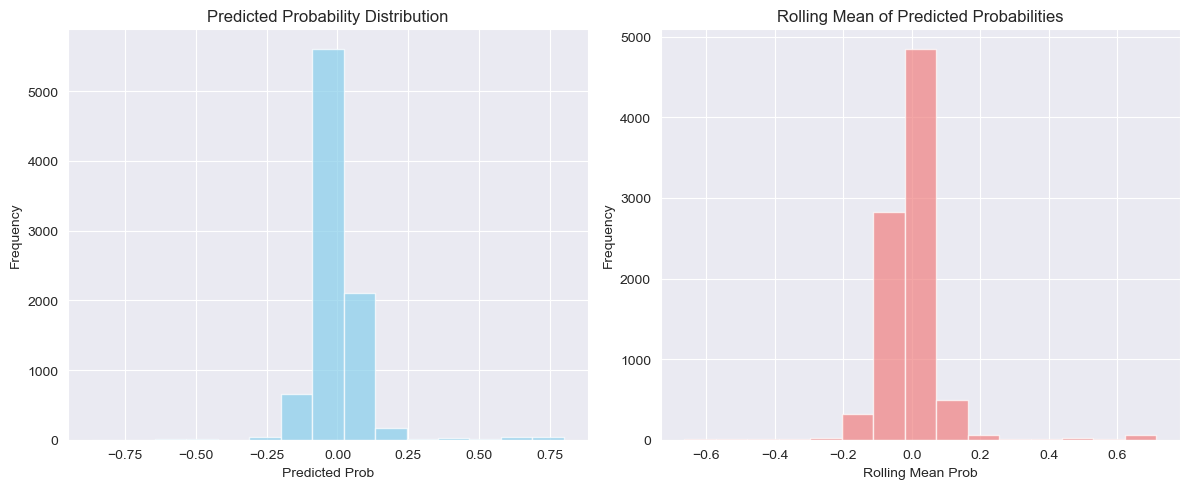

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_value'][200:], bins=15, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][200:], bins=15, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


375
2025-01-01 00:39:35.104000: BUY_OPEN 26.76 @ 3361.29 (Prob: 0.0796) | Capital: 100000.00
2025-01-03 15:35:47.485000: SELL_CLOSE_LONG 26.76 @ 3545.74 | PnL: 4888.68 | Capital: 104888.68 | Reason: Long Take Profit Hit
2025-01-03 15:46:17.739000: BUY_OPEN 26.40 @ 3574.50 (Prob: 0.1035) | Capital: 104888.68
2025-01-07 19:40:46.286000: SELL_CLOSE_LONG 26.40 @ 3394.88 | PnL: -4786.02 | Capital: 100102.66 | Reason: Long Stop Loss Hit
2025-01-08 11:33:31.352000: SELL_SHORT_OPEN -27.03 @ 3331.15 (Prob: -0.0655) | Capital: 100102.66
2025-01-09 20:10:56.104000: BUY_TO_COVER_SHORT 27.03 @ 3173.14 | PnL: 4228.35 | Capital: 104331.00 | Reason: Short Take Profit Hit
2025-01-09 20:33:34.051000: SELL_SHORT_OPEN -29.42 @ 3189.94 (Prob: -0.0999) | Capital: 104331.00
2025-01-13 13:09:02.349000: BUY_TO_COVER_SHORT 29.42 @ 3074.85 | PnL: 3340.67 | Capital: 107671.67 | Reason: 
2025-01-13 14:02:43.770000: BUY_OPEN 31.71 @ 3054.24 (Prob: 0.0600) | Capital: 107671.67
2025-01-14 09:24:18.216000: SELL_CLOSE_

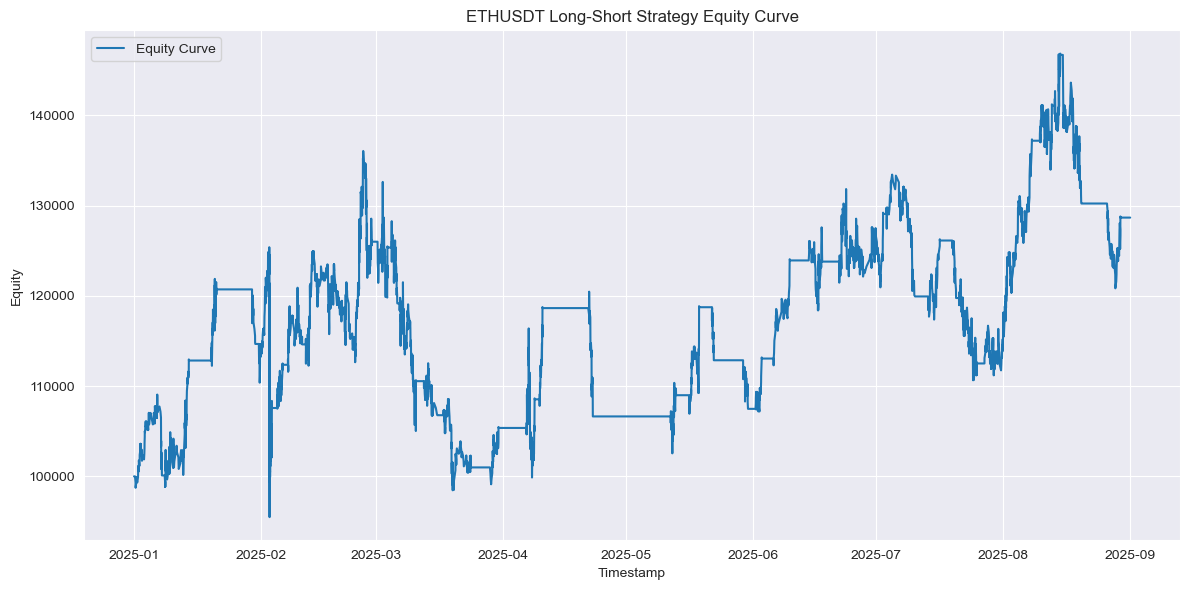

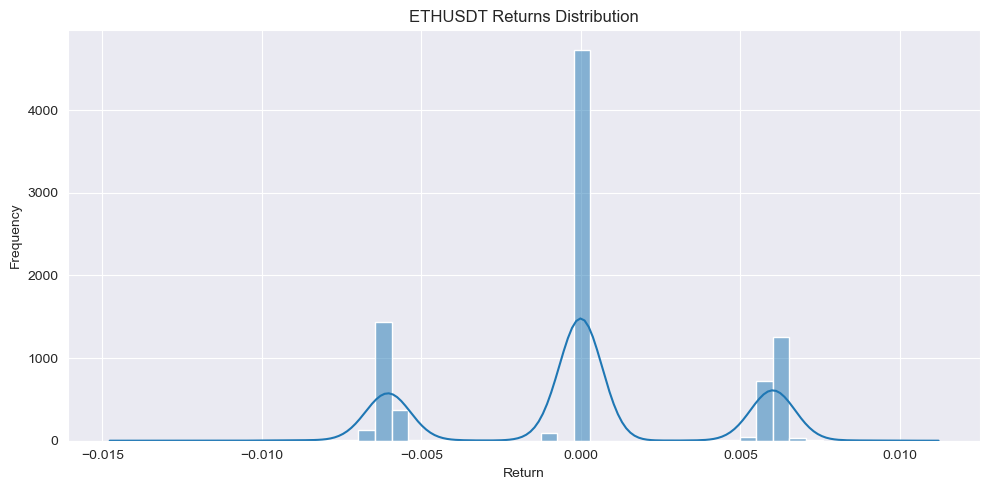

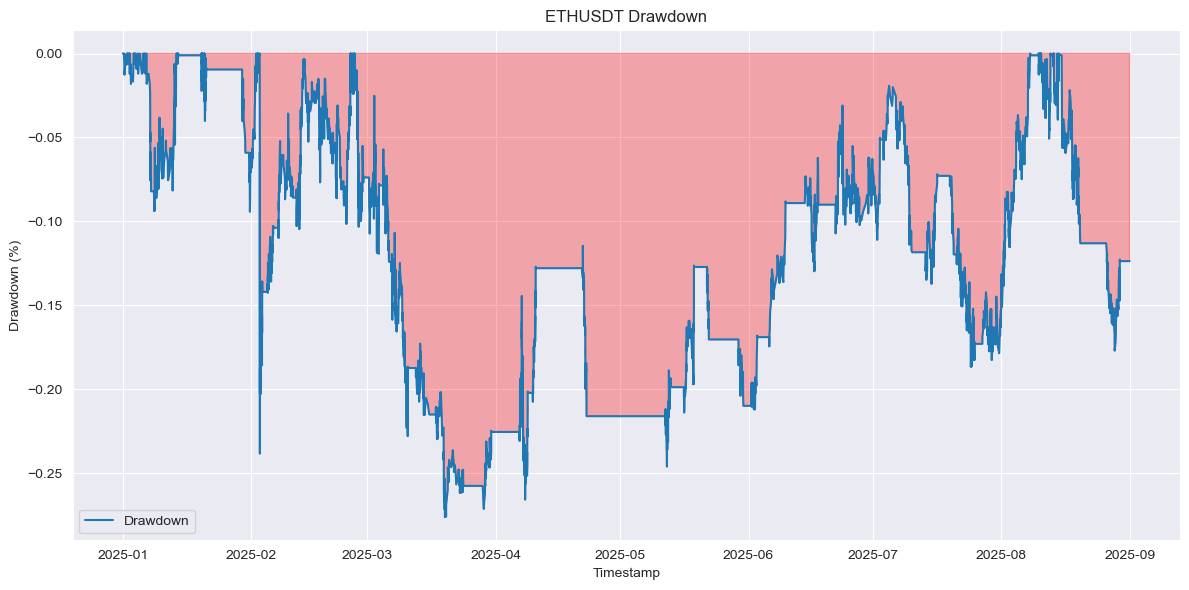

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

ma_window = int(feat_norm_rolling_mean_window)
print(ma_window)
# ma_window = 50

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='us') # Assuming microseconds
all_predictions_df['ma'] = all_predictions_df['px'].rolling(window=ma_window).mean()

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.0007   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.06 # Predicted probability above this to go long (buy)
short_threshold = -0.06 # Predicted probability below this to go short (sell)

beta = 5
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

step = 0

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    ma = df['ma'].iloc[i]
    current_rolling_std = current_px * 0.01
    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold:# and current_px > ma: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold:# and current_px < ma: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1

        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close or step > future_window:
            step = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1

        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close or step > future_window:
            step = 0

            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)
print("ma")

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


375
2025-01-04 20:43:21.785000: BUY_OPEN 24.59 @ 3658.33 (Prob: 0.0789) | Capital: 100000.00
2025-01-07 15:39:14.868000: SELL_CLOSE_LONG 24.59 @ 3465.17 | PnL: -4792.14 | Capital: 95207.86 | Reason: Long Stop Loss Hit
2025-01-07 15:39:31.984000: SELL_SHORT_OPEN -24.88 @ 3441.91 (Prob: -0.1017) | Capital: 95207.86
2025-01-08 17:03:45.267000: BUY_TO_COVER_SHORT 24.88 @ 3268.74 | PnL: 4268.34 | Capital: 99476.20 | Reason: Short Take Profit Hit
2025-01-08 17:03:46.269000: SELL_SHORT_OPEN -27.20 @ 3289.96 (Prob: -0.0884) | Capital: 99476.20
2025-01-10 16:45:32.884000: BUY_TO_COVER_SHORT 27.20 @ 3261.87 | PnL: 719.49 | Capital: 100195.69 | Reason: 
2025-01-19 23:45:42.054000: BUY_OPEN 27.89 @ 3231.65 (Prob: 0.0948) | Capital: 100195.69
2025-01-20 06:52:26.913000: SELL_CLOSE_LONG 27.89 @ 3409.29 | PnL: 4906.89 | Capital: 105102.58 | Reason: Long Take Profit Hit
2025-01-20 13:40:04.685000: SELL_SHORT_OPEN -28.51 @ 3316.47 (Prob: -0.0668) | Capital: 105102.58
2025-01-21 02:43:54.023000: BUY_TO_

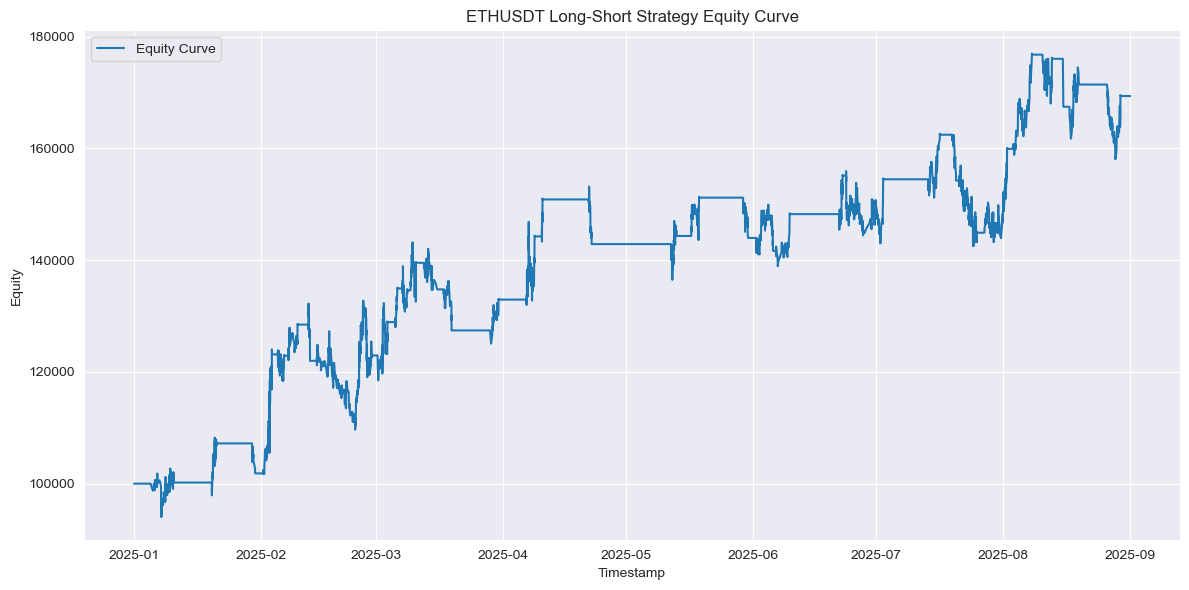

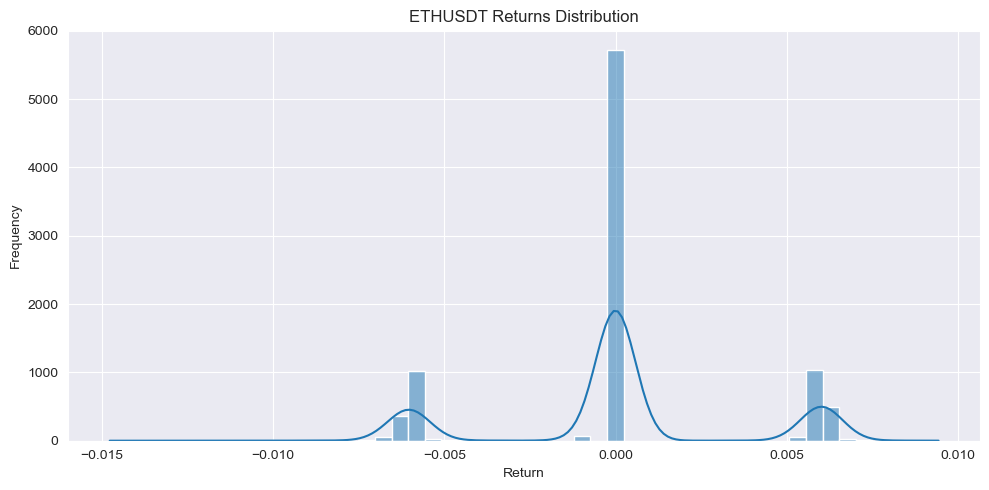

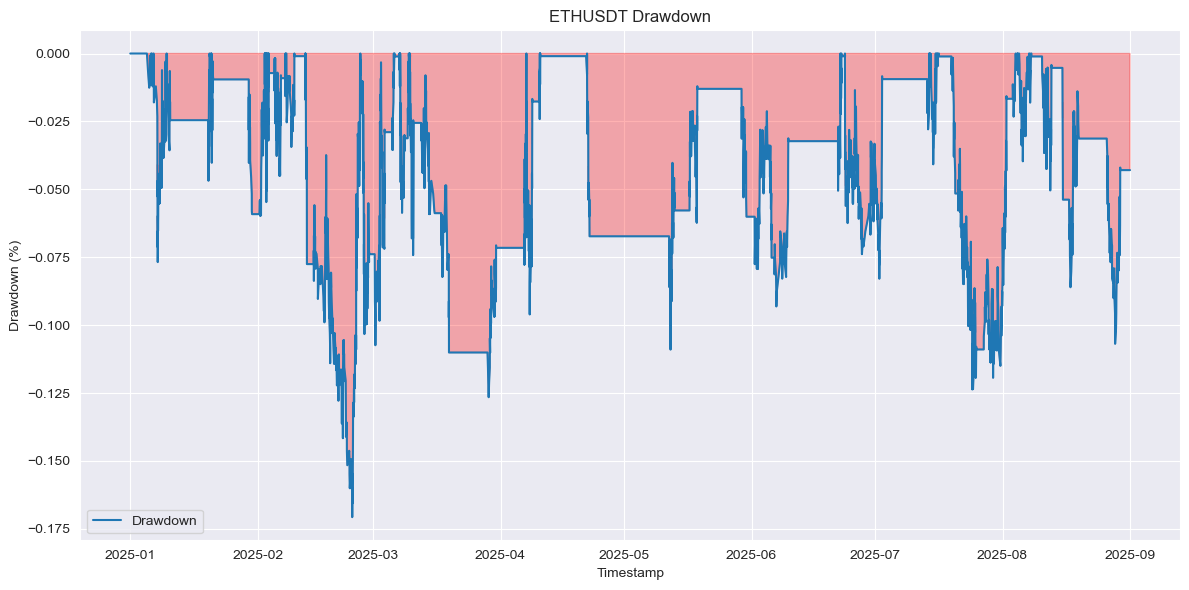

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

ma_window = int(feat_norm_rolling_mean_window)
print(ma_window)
ma_window = 50

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='us') # Assuming microseconds
all_predictions_df['ma'] = all_predictions_df['px'].rolling(window=ma_window).mean()

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.0007   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
# long_threshold = 0.02 # Predicted probability above this to go long (buy)
# short_threshold = -0.02 # Predicted probability below this to go short (sell)
#
# beta = 3
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

step = 0

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    ma = df['ma'].iloc[i]
    current_rolling_std = current_px * 0.01
    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold and current_px > ma: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold and current_px < ma: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1
        
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close or step > future_window:
            step = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")
            
            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1

        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close or step > future_window:
            step = 0

            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)
print("ma")

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [25]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


In [26]:
# print(len(feature_cols))
# results = []
# all_tab_inc_test_predictions = []
# all_tabnet_test_predictions = []
# all_lgb_test_predictions = []
#
# lgb_model = None
# tab_inc = None
# tab_inc_flag = 0
#
# train_dfs = split_dataframes[-n_train_terms:]
#
# train_df = pl.concat(train_dfs)
#
# train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_train = train_df_processed[feature_cols]
# y_train = train_df_processed[target_col]
# px_train = train_df_processed['px']
#
#
# tabnet = TabNetRegressor(**params)
# tabnet.fit(
#     X_train=X_train.values,
#     y_train=y_train.values.reshape(-1, 1),
#     **init_fit_params,
# )
# print("1")

In [27]:
# save_tabnet_checkpoint(
#     model=tabnet,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc_regressor",
#     model_params=params,
#     feature_names=X_train.columns,
#     training_meta={
#         "symbol": symbol,
#         "train_n_terms": n_train_terms,
#         "init_fit_params": init_fit_params,
#         "label_window": future_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "feat_cal_window": int(feat_cal_window),
#         "feat_norm_window": feat_norm_window,
#         "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_ma_window": ma_window,
#         "bt_beta": beta,
#         "bt_ret": total_return,
#         "bt_dd": max_drawdown,
#         "bt_n_trade": len(trades),
#     },
# )